# Blind Docking

In [ ]:
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem,rdFMCS, Draw

import sys, os, random, time
sys.path.insert(1, 'utilities/')

from multiprocessing import Pool

import warnings
warnings.filterwarnings("ignore")

%config Completer.use_jedi = False

### Setting the working directory

In [ ]:
os.chdir('./test/Blind_Docking/')

### Loading the system from PDB

In [ ]:
import MDAnalysis as mda
import requests
from rdkit import Chem
from rdkit.Chem import AllChem
import nglview as nv
import os

# Step 1: Load the PDB file
pdb_id = "{PDB_INPUT}"  # Replace with your PDB ID

# Step 2: Load into MDAnalysis
u = mda.Universe(f"{pdb_id}.pdb")

# Step 3: Select protein and ligand
protein = u.select_atoms("protein")
ligand = u.select_atoms("not protein and not resname HOH WAT TIP3")  # Typically organic or HETATM

# Step 4: Save protein as PDB
protein.write(f"{pdb_id}_clean.pdb")

# Step 5: Save ligand as PDB
lig_pdb = f"{pdb_id}_lig.pdb"
lig_mol2 = f"{pdb_id}_lig.mol2"
ligand.write(lig_pdb)

# Step 6: Convert PDB to MOL2 using Open Babel (requires openbabel CLI installed)
os.system(f'obabel -ipdb {lig_pdb} -omol2 -O {lig_mol2}')

# Step 7: Visualize with NGLView (optional)
view = nv.show_mdanalysis(u)
view.clear_representations()
view.add_representation("cartoon", selection="protein", color="white")
view.add_representation("ball+stick", selection="not protein and not water", color="element")
view.center()
view


*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is {PDB_INPUT}_lig.pdb)

1 molecule converted


NGLWidget()

### Protein sanitization

In [19]:
from pdbfixer import PDBFixer
from openmm.app import PDBFile
from MDAnalysis.coordinates import PDB

def fix_protein(filename='',addHs_pH=7.4,output='',try_renumberResidues=False):

    fix = PDBFixer(filename=filename)
    fix.findMissingResidues()
    fix.findNonstandardResidues()
    fix.replaceNonstandardResidues()
    fix.removeHeterogens(True)
    fix.findMissingAtoms()
    fix.addMissingAtoms()
    fix.addMissingHydrogens(addHs_pH)
    PDBFile.writeFile(fix.topology, fix.positions, open(output, 'w'))

    if try_renumberResidues == True:
        try:
            original=mda.Universe(filename)
            from_fix=mda.Universe(output)

            resNum=[res.resid for res in original.residues]
            for idx,res in enumerate(from_fix.residues):
                res.resid = resNum[idx]

            save=PDB.PDBWriter(filename=output)
            save.write(from_fix)
            save.close()
        except Exception:
            print('Not possible to renumber residues, check excepton for extra details')

In [21]:
fix_protein(filename='{PDB_INPUT}_clean.pdb', output='{PDB_INPUT}_fixed.pdb', try_renumberResidues=True)

### Ligand sanitization

[17:24:46] {PDB_INPUT}_lig.pdb: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


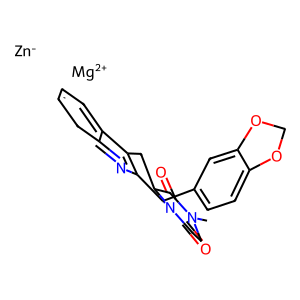

In [22]:
m=Chem.MolFromMol2File('{PDB_INPUT}_lig.mol2',False)
Draw.MolToImage(m)

In [23]:
from openbabel import pybel

mol= [m for m in pybel.readfile(filename='{PDB_INPUT}_lig.mol2',format='mol2')][0]
mol.addh()
out=pybel.Outputfile(filename='{PDB_INPUT}_lig_H.mol2',format='mol2',overwrite=True)
out.write(mol)
out.close()

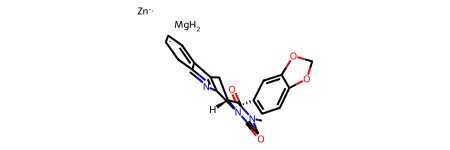

In [24]:
m=Chem.MolFromMol2File('{PDB_INPUT}_lig_H.mol2')
m

### System visualization

In [25]:
import nglview as nv

# Create an empty NGLWidget
view = nv.NGLWidget()

# Add protein component
view.add_component('{PDB_INPUT}_clean_H.pdb')  # index 0
view[0].clear_representations()
view[0].add_representation('cartoon', color='white')
view[0].add_surface(opacity=0.6, color='white')

# Add ligand component
view.add_component('{PDB_INPUT}_lig_H.mol2')  # index 1
view[1].clear_representations()
view[1].add_representation('ball+stick', color_scheme='greenCarbon', radius=0.2)

# Center and display
view.center()
view


NGLWidget()

## Molecular docking

### Protein pockets identification

In [ ]:
!../../bin/fpocket -f {'{PDB_INPUT}_clean_H.pdb'} -d > {'pocket_descriptors.csv'}

In [31]:
pockets_data=pd.read_csv('pocket_descriptors.csv',sep=' ',index_col=[0])
pockets_data

,drug_score,volume,nb_asph,inter_chain,apol_asph_proportion,mean_asph_radius,as_density,mean_asph_solv_acc,mean_loc_hyd_dens,flex,...,val,trp,tyr,chain_1_type,chain_2_type,num_res_chain_1,num_res_chain_2,lig_het_tag,name_chain_1,name_chain_2
cav_id,,,,,,,,,,,,,,,,,,,,,
1,0.8741,1056.8893,139,0,0.6331,4.0200,6.8663,0.4647,60.2955,0.0,...,0,1,2,0,0,324,324,NaN,A,A
2,0.0452,574.1936,72,0,0.3333,3.7437,5.5622,0.4716,19.5833,0.0,...,0,1,0,0,0,324,324,NaN,A,A
3,0.0003,498.4859,37,0,0.3243,4.0605,5.1642,0.5894,10.6667,0.0,...,0,0,1,0,0,324,324,NaN,A,A
4,0.0009,111.4924,23,0,0.3913,3.5100,2.0155,0.3504,8.0000,0.0,...,0,0,0,0,0,324,324,NaN,A,A
5,0.0021,386.4537,30,0,0.4667,3.9872,4.2452,0.6120,11.7143,0.0,...,0,0,0,0,0,324,324,NaN,A,A
6,0.0046,232.4288,34,0,0.4706,3.8398,3.2787,0.4623,15.0000,0.0,...,0,1,0,0,0,324,324,NaN,A,A
7,0.0005,222.1116,16,0,0.6250,3.9237,2.4631,0.6783,9.0000,0.0,...,0,0,0,0,0,324,324,NaN,A,A
8,0.0004,214.0768,15,0,0.2667,3.9367,2.9664,0.5179,3.0000,0.0,...,0,1,0,0,0,324,324,NaN,A,A
9,0.0012,272.4921,33,0,0.6061,4.1402,2.1593,0.6400,19.0000,0.0,...,0,0,0,0,0,324,324,NaN,A,A


### Pockets visualization

In [32]:
import nglview as nv
import os
import random

# Initialize NGLView widget
view = nv.NGLWidget()

# --- Protein ---
view.add_component('{PDB_INPUT}_clean_H.pdb')  # Component 0
view[0].clear_representations()
view[0].add_representation('cartoon', color='white')  # Similar to py3Dmol cartoon
# nglview doesn't support outline borders like py3Dmol.setViewStyle

# --- Ligand ---
view.add_component('{PDB_INPUT}_lig_H.mol2')  # Component 1
view[1].clear_representations()
view[1].add_representation('ball+stick', color_scheme='element', radius=0.1)
# greenCarbon isn't directly supported, but color_scheme='element' gives standard CPK colors

# --- Electrostatics/PQR Points ---
pqr_dir = '{PDB_INPUT}_clean_H_out/'
for filename in os.listdir(pqr_dir):
    if filename.endswith('.pqr'):
        filepath = os.path.join(pqr_dir, filename)
        view.add_component(filepath)
        color = "#" + ''.join(random.choices('0123456789ABCDEF', k=6))
        view[-1].clear_representations()
        view[-1].add_representation('spacefill', color=color, opacity=0.6)

# Zoom to all components
view.center()
view


NGLWidget()

### Per-pocket docking box set up (vina)
Hint: You may think about extending the pocket box by 4-5 armostrongs ...

In [33]:
import MDAnalysis as mda
import os
import numpy as np
import pandas as pd

# Preset: pockets_data is a DataFrame indexed by pocket number
# Example: pockets_data = pd.DataFrame(index=range(1, 11))

def compute_box(atomgroup, buffer=5.0):
    positions = atomgroup.positions
    min_coords = positions.min(axis=0) - buffer
    max_coords = positions.max(axis=0) + buffer
    center = (min_coords + max_coords) / 2
    size = max_coords - min_coords
    return {
        'center_x': center[0], 'center_y': center[1], 'center_z': center[2]
    }, {
        'size_x': size[0], 'size_y': size[1], 'size_z': size[2]
    }

# Path to directory with .pqr pocket files
pqr_dir = '{PDB_INPUT}_clean_H_out/'

# Loop over each pocket file
for file in os.listdir(pqr_dir):
    if file.endswith('.pqr') and 'pocket' in file:
        pocket_num = int(file.split('_')[0].replace('pocket', ''))
        filepath = os.path.join(pqr_dir, file)

        # Load using MDAnalysis
        u = mda.Universe(filepath)
        ag = u.atoms

        # Compute box with 5 Å buffer
        center, size = compute_box(ag, buffer=5.0)

        # Populate DataFrame
        pockets_data.loc[pocket_num, 'center_x'] = center['center_x']
        pockets_data.loc[pocket_num, 'center_y'] = center['center_y']
        pockets_data.loc[pocket_num, 'center_z'] = center['center_z']
        pockets_data.loc[pocket_num, 'size_x'] = size['size_x']
        pockets_data.loc[pocket_num, 'size_y'] = size['size_y']
        pockets_data.loc[pocket_num, 'size_z'] = size['size_z']


In [34]:
pockets_data.head(10)

,drug_score,volume,nb_asph,inter_chain,apol_asph_proportion,mean_asph_radius,as_density,mean_asph_solv_acc,mean_loc_hyd_dens,flex,...,num_res_chain_2,lig_het_tag,name_chain_1,name_chain_2,center_x,center_y,center_z,size_x,size_y,size_z
cav_id,,,,,,,,,,,,,,,,,,,,,
1,0.8741,1056.8893,139,0,0.6331,4.0200,6.8663,0.4647,60.2955,0.0,...,324,NaN,A,A,47.153000,36.187000,15.229000,20.326000,18.056000,24.312000
2,0.0452,574.1936,72,0,0.3333,3.7437,5.5622,0.4716,19.5833,0.0,...,324,NaN,A,A,39.917500,46.821999,12.002501,18.320999,23.436001,15.865002
3,0.0003,498.4859,37,0,0.3243,4.0605,5.1642,0.5894,10.6667,0.0,...,324,NaN,A,A,24.391001,19.911999,19.753000,18.076000,18.219999,19.172001
4,0.0009,111.4924,23,0,0.3913,3.5100,2.0155,0.3504,8.0000,0.0,...,324,NaN,A,A,33.264500,32.007500,29.854000,13.457001,13.223000,11.883997
5,0.0021,386.4537,30,0,0.4667,3.9872,4.2452,0.6120,11.7143,0.0,...,324,NaN,A,A,26.427002,30.581501,35.598000,17.528002,16.167002,16.634003
6,0.0046,232.4288,34,0,0.4706,3.8398,3.2787,0.4623,15.0000,0.0,...,324,NaN,A,A,38.223499,29.394001,29.178499,11.913002,12.837999,17.578999
7,0.0005,222.1116,16,0,0.6250,3.9237,2.4631,0.6783,9.0000,0.0,...,324,NaN,A,A,35.526501,15.045000,26.638000,15.500999,11.121999,12.117998
8,0.0004,214.0768,15,0,0.2667,3.9367,2.9664,0.5179,3.0000,0.0,...,324,NaN,A,A,28.457500,48.134499,40.513496,14.118998,13.151001,14.659000
9,0.0012,272.4921,33,0,0.6061,4.1402,2.1593,0.6400,19.0000,0.0,...,324,NaN,A,A,33.536999,17.919500,15.523001,14.968000,13.763000,13.890000


### Docking with Smina 

In [ ]:
for pocket in pockets_data.index:
    rec = '{PDB_INPUT}_clean_H.pdb' 
    lig = '{PDB_INPUT}_lig_H.mol2'
    outfile = 'smina_outfiles/{PDB_INPUT}_lig_pocket_'+str(pocket)+'.sdf'
    center_x = pockets_data.loc[pocket,'center_x']
    center_y = pockets_data.loc[pocket,'center_y']
    center_z = pockets_data.loc[pocket,'center_z']
    size_x = pockets_data.loc[pocket,'size_x']
    size_y = pockets_data.loc[pocket,'size_y']
    size_z = pockets_data.loc[pocket,'size_z']
    
    !../../bin/smina.osx -r {rec} -l {lig} -o {outfile} --center_x {center_x} --center_y {center_y} --center_z {center_z} --size_x {size_x} --size_y {size_y} --size_z {size_z} --exhaustiveness 8 --num_modes 5 >> {'smina.log'}

In [37]:
import nglview as nv
import os
import random
from rdkit import Chem

# Create viewer
view = nv.NGLWidget()

# --- Load protein ---
view.add_component('{PDB_INPUT}_clean_H.pdb')
view[0].clear_representations()
view[0].add_representation('cartoon', color='white')

# --- Load ligand ---
view.add_component('{PDB_INPUT}_lig_H.mol2')
view[1].clear_representations()
view[1].add_representation('ball+stick', color='green', radius=0.1)

# --- Load pocket surfaces (.pqr files) ---
for file in os.listdir('{PDB_INPUT}_clean_H_out/'):
    if file.endswith('.pqr'):
        filepath = os.path.join('{PDB_INPUT}_clean_H_out', file)
        view.add_component(filepath)
        color = "#" + ''.join(random.choices('0123456789ABCDEF', k=6))
        view[-1].clear_representations()
        view[-1].add_representation('spacefill', color=color, opacity=0.5)

# --- Load Smina poses (.sdf) as thin sticks ---
for file in os.listdir('smina_outfiles/'):
    if file.endswith('.sdf'):
        poses = Chem.SDMolSupplier(os.path.join('smina_outfiles', file))
        color = "#" + ''.join(random.choices('0123456789ABCDEF', k=6))
        for pose in poses:
            if pose is None:
                continue
            molblock = Chem.MolToMolBlock(pose)
            with open('tmp_pose.mol', 'w') as f:
                f.write(molblock)
            view.add_component('tmp_pose.mol')
            view[-1].clear_representations()
            view[-1].add_representation('ball+stick', color=color, radius=0.05)

# Final view adjustment
view.center()
view


[17:52:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:52:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:52:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:52:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:52:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:52:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:52:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:52:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:52:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

NGLWidget()